In [34]:
# Setup visualization helpers
import os
from pathlib import Path
from collections import defaultdict
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from IPython.display import display

ROOT = Path.cwd()
DATA_DIR = ROOT / 'exported_patches'
OUT_DIR = ROOT / 'viz_outputs'

In [35]:
def find_oed_files(data_dir):
    files = []
    for root, _, filenames in os.walk(data_dir):
        for f in filenames:
            if f.startswith('OED_'):
                files.append(Path(root) / f)
    return files

def group_by_class(paths):
    groups = defaultdict(list)
    for p in paths:
        groups[p.parent.name].append(p)
    return groups

def make_thumbnail(img_path, size=(128,128)):
    with Image.open(img_path) as im:
        im = im.convert('RGB')
        im.thumbnail(size)
        return np.array(im)

def plot_counts(groups):
    classes = list(groups.keys())
    counts = [len(groups[c]) for c in classes]
    plt.figure(figsize=(6,4))
    plt.bar(classes, counts, color=['#4c72b0','#55a868'])
    plt.ylabel('Number of patches')
    plt.title('Patch counts per class (OED_ prefixed files only)')
    plt.xticks(rotation=15)
    plt.tight_layout()
    OUT_DIR.mkdir(exist_ok=True)
    p = OUT_DIR / 'counts.png'
    plt.savefig(p, dpi=150)
    plt.close()
    return p

def plot_samples(groups, samples_per_class=8):
    classes = list(groups.keys())
    rows = len(classes)
    cols = samples_per_class
    fig, axes = plt.subplots(rows, cols, figsize=(cols*1.5, rows*1.5))
    if rows == 1:
        axes = np.expand_dims(axes, 0)
    for i, cls in enumerate(classes):
        paths = groups[cls][:samples_per_class]
        for j in range(cols):
            ax = axes[i, j]
            ax.axis('off')
            if j < len(paths):
                thumb = make_thumbnail(paths[j])
                ax.imshow(thumb)
        # Add row label
        axes[i, 0].text(-0.1, 0.5, cls, transform=axes[i, 0].transAxes, 
                       fontsize=10, verticalalignment='center', 
                       horizontalalignment='right', fontweight='bold')
    plt.suptitle('Sample patches per class (OED_ only)')
    plt.tight_layout()
    p = OUT_DIR / 'samples_grid.png'
    plt.savefig(p, dpi=150)
    plt.close()
    return p

Run the next code cell to generate and display visualizations.
The notebook scans `exported_patches/exported_patches` and only includes files whose filename starts with `OED_`.

Classes found: High Risk OED, Low Risk OED


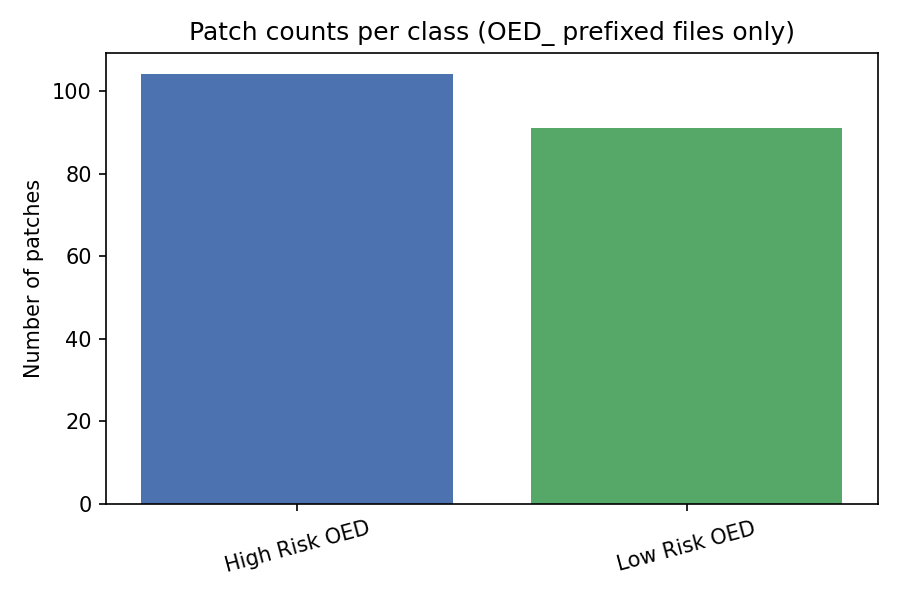

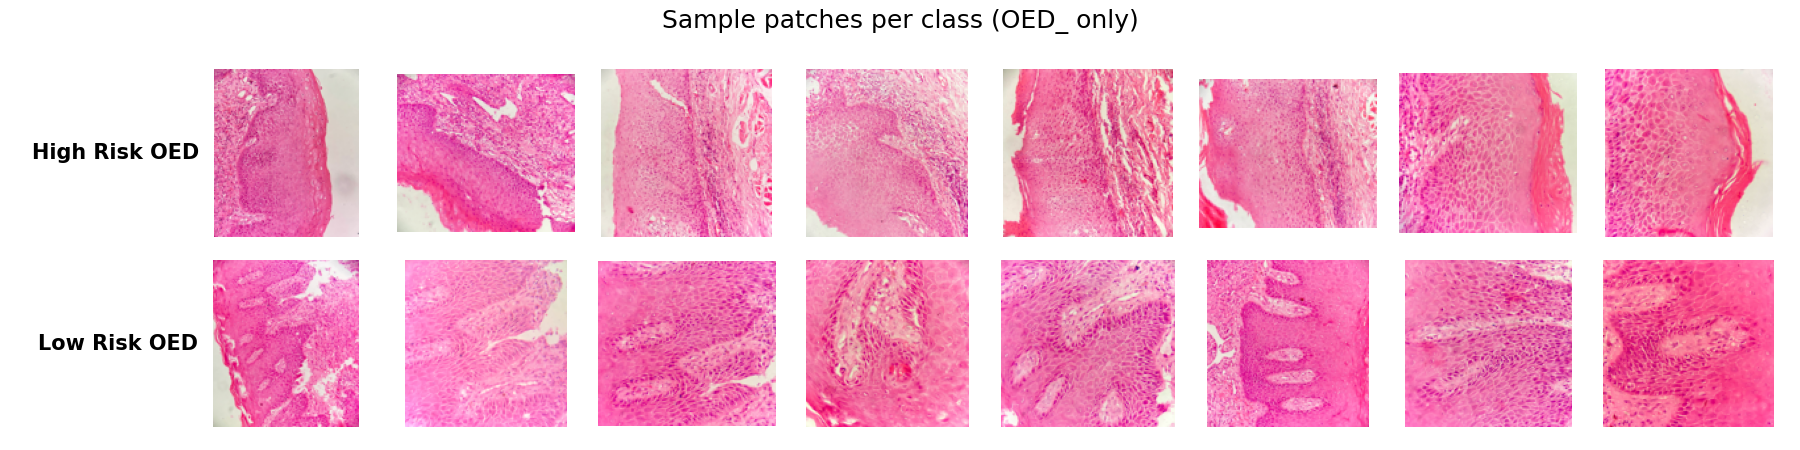

In [36]:
# Generate visualizations and display them inline
files = find_oed_files(DATA_DIR)
if not files:
    print('No OED_ files found in', DATA_DIR)
else:
    groups = group_by_class(files)
    print('Classes found:', ', '.join(groups.keys()))
    cpath = plot_counts(groups)
    spath = plot_samples(groups)
    from IPython.display import Image as DispImage
    display(DispImage(str(cpath)))
    display(DispImage(str(spath)))

## ML Model Training

Train a classifier to distinguish between High Risk and Low Risk OED patches using transfer learning.

In [37]:
# Load image data and create dataset with labels
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch import nn
import warnings
warnings.filterwarnings('ignore')

def load_images_with_labels(data_dir, max_samples=None, target_size=(224, 224)):
    """Load all images and their corresponding labels from directory structure.
    
    Images are resized to target_size to handle variable image dimensions.
    """
    X = []
    y = []
    class_map = {}
    
    # Map class names to labels
    for class_name in sorted(os.listdir(data_dir)):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            class_id = len(class_map)
            class_map[class_name] = class_id
    
    # Load images
    sample_count = 0
    skipped_count = 0
    for class_name, class_id in class_map.items():
        class_path = os.path.join(data_dir, class_name)
        for img_file in os.listdir(class_path):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(class_path, img_file)
                try:
                    img = Image.open(img_path).convert('RGB')
                    # Resize image to standard size to handle variable dimensions
                    img = img.resize(target_size, Image.Resampling.LANCZOS)
                    img_array = np.array(img)
                    X.append(img_array)
                    y.append(class_id)
                    sample_count += 1
                    if max_samples and sample_count >= max_samples:
                        break
                except Exception as e:
                    print(f'Error loading {img_path}: {e}')
                    skipped_count += 1
        if max_samples and sample_count >= max_samples:
            break
    
    return np.array(X), np.array(y), class_map

print('Loading image data...')
X, y, class_map = load_images_with_labels(str(DATA_DIR))
print(f'Loaded {len(X)} images from {len(class_map)} classes')
print(f'Image shape: {X.shape}')
print(f'Class mapping: {class_map}')
print(f'Class distribution: {np.bincount(y)}')

Loading image data...
Loaded 195 images from 2 classes
Image shape: (195, 224, 224, 3)
Class mapping: {'High Risk OED': 0, 'Low Risk OED': 1}
Class distribution: [104  91]


In [38]:
# Data Augmentation to expand the dataset (supports PIL or Albumentations)
from PIL import ImageEnhance, ImageOps
import random
import albumentations as A


def augment_image_pil(img, num_augmentations=3):
    """Generate augmented versions of an image using PIL operations"""
    augmented_images = [img]  # Include original
    
    for _ in range(num_augmentations):
        aug_img = img.copy()
        
        # Random rotation (±15 degrees)
        if random.random() > 0.5:
            angle = random.uniform(-15, 15)
            aug_img = aug_img.rotate(angle, expand=False, fillcolor=(128, 128, 128))
        
        # Random horizontal flip
        if random.random() > 0.5:
            aug_img = ImageOps.mirror(aug_img)
        
        # Random brightness adjustment
        if random.random() > 0.5:
            enhancer = ImageEnhance.Brightness(aug_img)
            factor = random.uniform(0.8, 1.2)
            aug_img = enhancer.enhance(factor)
        
        # Random contrast adjustment
        if random.random() > 0.5:
            enhancer = ImageEnhance.Contrast(aug_img)
            factor = random.uniform(0.8, 1.2)
            aug_img = enhancer.enhance(factor)
        
        # Random sharpness adjustment
        if random.random() > 0.5:
            enhancer = ImageEnhance.Sharpness(aug_img)
            factor = random.uniform(0.5, 1.5)
            aug_img = enhancer.enhance(factor)
        
        augmented_images.append(aug_img)
    
    return augmented_images

def augment_dataset(X, y, augmentations_per_image=3, use_albumentations=False):
    """
    Augment the entire dataset by creating multiple versions of each image.
    
    Parameters:
    -----------
    X : numpy array of images
    y : numpy array of labels
    augmentations_per_image : int, number of augmented versions per original image
    use_albumentations : bool, if True use albumentations library, else use PIL
    """
    
    X_augmented = []
    y_augmented = []
    
    if use_albumentations:
        print('Augmenting dataset using Albumentations...')
        # Define albumentations pipeline
        augmentation = A.Compose([
            A.Rotate(limit=15, p=0.7, border_mode=0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.3),
            A.GaussNoise(p=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.6),
            A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05, p=0.5),
            A.GaussianBlur(blur_limit=3, p=0.3),
            A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=0.3),
        ])
        
        for i, (img_array, label) in enumerate(zip(X, y)):
            if i % 50 == 0:
                print(f'Processing image {i+1}/{len(X)}...')
            
            # Add original image
            X_augmented.append(img_array)
            y_augmented.append(label)
            
            # Generate augmented versions
            for _ in range(augmentations_per_image):
                augmented = augmentation(image=img_array)
                X_augmented.append(augmented['image'])
                y_augmented.append(label)
    else:
        print('Augmenting dataset using PIL...')
        for i, (img_array, label) in enumerate(zip(X, y)):
            if i % 50 == 0:
                print(f'Processing image {i+1}/{len(X)}...')
            
            # Convert numpy array to PIL Image
            img = Image.fromarray(img_array.astype('uint8'))
            
            # Generate augmented versions
            augmented_imgs = augment_image_pil(img, num_augmentations=augmentations_per_image)
            
            # Add all versions (original + augmented) to the dataset
            for aug_img in augmented_imgs:
                aug_array = np.array(aug_img)
                X_augmented.append(aug_array)
                y_augmented.append(label)
    
    return np.array(X_augmented), np.array(y_augmented)

# CONFIGURE AUGMENTATION METHOD HERE
# Set use_albumentations=False for PIL (faster, already installed)
# Set use_albumentations=True for Albumentations (more augmentations, auto-installs if needed)
USE_ALBUMENTATIONS = False

# Apply augmentation (3 additional augmented versions per image = 4x dataset)
X_augmented, y_augmented = augment_dataset(X, y, augmentations_per_image=3, use_albumentations=USE_ALBUMENTATIONS)

print(f'\nOriginal dataset size: {len(X)}')
print(f'Augmented dataset size: {len(X_augmented)}')
print(f'Augmentation method: {"Albumentations" if USE_ALBUMENTATIONS else "PIL"}')
print(f'Expansion factor: {len(X_augmented) / len(X):.1f}x')
print(f'Augmented class distribution: {np.bincount(y_augmented)}')

# Replace the original dataset with the augmented one
X = X_augmented
y = y_augmented

Augmenting dataset using PIL...
Processing image 1/195...
Processing image 51/195...
Processing image 101/195...
Processing image 151/195...

Original dataset size: 195
Augmented dataset size: 780
Augmentation method: PIL
Expansion factor: 4.0x
Augmented class distribution: [416 364]


In [39]:
# Extract features using a pre-trained ResNet model
def extract_features_resnet(images):
    """Extract features from images using pre-trained ResNet50"""
    device = torch.device('cpu')
    model = models.resnet50(pretrained=True).to(device)
    model = nn.Sequential(*list(model.children())[:-1])  # Remove classification layer
    model.eval()
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
    ])
    
    features_list = []
    with torch.no_grad():
        for i, img in enumerate(images):
            if i % 50 == 0:
                print(f'Processing image {i+1}/{len(images)}...')
            img_tensor = transform(Image.fromarray(img.astype('uint8'))).unsqueeze(0).to(device)
            feat = model(img_tensor).cpu().numpy().flatten()
            features_list.append(feat)
    
    return np.array(features_list)

print('Extracting features using ResNet50...')
X_features = extract_features_resnet(X)
print(f'Feature shape: {X_features.shape}')

Extracting features using ResNet50...
Processing image 1/780...
Processing image 51/780...
Processing image 101/780...
Processing image 151/780...
Processing image 201/780...
Processing image 251/780...
Processing image 301/780...
Processing image 351/780...
Processing image 401/780...
Processing image 451/780...
Processing image 501/780...
Processing image 551/780...
Processing image 601/780...
Processing image 651/780...
Processing image 701/780...
Processing image 751/780...
Feature shape: (780, 2048)


In [40]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f'Training set size: {X_train_scaled.shape[0]}')
print(f'Test set size: {X_test_scaled.shape[0]}')
print(f'Training set class distribution: {np.bincount(y_train)}')
print(f'Test set class distribution: {np.bincount(y_test)}')

Training set size: 624
Test set size: 156
Training set class distribution: [333 291]
Test set class distribution: [83 73]


In [41]:
# Train a Random Forest classifier
print('Training Random Forest classifier...')
clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    random_state=42,
    n_jobs=-1,
    verbose=1
)
clf.fit(X_train_scaled, y_train)
print('Training complete!')

Training Random Forest classifier...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s


Training complete!


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished


In [42]:
# Evaluate the model
y_pred_train = clf.predict(X_train_scaled)
y_pred_test = clf.predict(X_test_scaled)

# Get probability predictions
y_pred_proba = clf.predict_proba(X_test_scaled)

# Calculate metrics
train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test, average='weighted')
recall = recall_score(y_test, y_pred_test, average='weighted')
f1 = f1_score(y_test, y_pred_test, average='weighted')

print('='*50)
print('MODEL PERFORMANCE')
print('='*50)
print(f'Training Accuracy:  {train_acc:.4f}')
print(f'Test Accuracy:      {test_acc:.4f}')
print(f'Precision (weighted): {precision:.4f}')
print(f'Recall (weighted):    {recall:.4f}')
print(f'F1-Score (weighted):  {f1:.4f}')
print('='*50)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


MODEL PERFORMANCE
Training Accuracy:  1.0000
Test Accuracy:      0.8654
Precision (weighted): 0.8656
Recall (weighted):    0.8654
F1-Score (weighted):  0.8652


[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


In [ ]:
# Alternative: Train a Linear SVM classifier
from sklearn.svm import LinearSVC
from scipy.special import expit

print('Training Linear SVM classifier...')
svm_clf = LinearSVC(
    C=1.0,  # Regularization strength (lower = stronger regularization)
    max_iter=2000,  # Maximum iterations
    random_state=42,
    dual=False,  # Faster for n_samples > n_features
    class_weight='balanced'  # Handle class imbalance
)
svm_clf.fit(X_train_scaled, y_train)
print('Linear SVM Training complete!')

# Evaluate Linear SVM
svm_pred_train = svm_clf.predict(X_train_scaled)
svm_pred_test = svm_clf.predict(X_test_scaled)

# Get decision function scores and convert to probabilities
svm_decision_test = svm_clf.decision_function(X_test_scaled)

# Convert decision scores to probabilities using sigmoid
if len(np.unique(y)) == 2:
    svm_proba_test = expit(svm_decision_test)
    svm_proba_test = np.column_stack([1 - svm_proba_test, svm_proba_test])
else:
    svm_proba_test = expit(svm_decision_test)
    svm_proba_test = svm_proba_test / svm_proba_test.sum(axis=1, keepdims=True)

# Calculate metrics for Linear SVM
svm_train_acc = accuracy_score(y_train, svm_pred_train)
svm_test_acc = accuracy_score(y_test, svm_pred_test)
svm_precision = precision_score(y_test, svm_pred_test, average='weighted')
svm_recall = recall_score(y_test, svm_pred_test, average='weighted')
svm_f1 = f1_score(y_test, svm_pred_test, average='weighted')

print('='*50)
print('LINEAR SVM PERFORMANCE')
print('='*50)
print(f'Training Accuracy:   {svm_train_acc:.4f}')
print(f'Test Accuracy:       {svm_test_acc:.4f}')
print(f'Precision (weighted): {svm_precision:.4f}')
print(f'Recall (weighted):    {svm_recall:.4f}')
print(f'F1-Score (weighted):  {svm_f1:.4f}')
print('='*50)

# Compare with Random Forest
print('\n' + '='*50)
print('MODEL COMPARISON: Linear SVM vs Random Forest')
print('='*50)
print(f'{"Metric":<20} {"Linear SVM":<15} {"Random Forest":<15}')
print('-'*50)
print(f'{"Train Accuracy":<20} {svm_train_acc:.4f}{"":>9} {train_acc:.4f}')
print(f'{"Test Accuracy":<20} {svm_test_acc:.4f}{"":>9} {test_acc:.4f}')
print(f'{"Precision":<20} {svm_precision:.4f}{"":>9} {precision:.4f}')
print(f'{"Recall":<20} {svm_recall:.4f}{"":>9} {recall:.4f}')
print(f'{"F1-Score":<20} {svm_f1:.4f}{"":>9} {f1:.4f}')
print('='*50)

# Compute confusion matrix for SVM
svm_cm = confusion_matrix(y_test, svm_pred_test)

# Create comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Random Forest Confusion Matrix
rf_cm = confusion_matrix(y_test, y_pred_test)
im0 = axes[0].imshow(rf_cm, cmap='Blues', aspect='auto')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_title(f'Random Forest Confusion Matrix\nAccuracy: {test_acc:.4f}')
class_names = [name for name, _ in sorted(class_map.items(), key=lambda x: x[1])]
axes[0].set_xticks(range(len(class_names)))
axes[0].set_yticks(range(len(class_names)))
axes[0].set_xticklabels(class_names, rotation=45, ha='right')
axes[0].set_yticklabels(class_names)
for i in range(len(class_names)):
    for j in range(len(class_names)):
        axes[0].text(j, i, str(rf_cm[i, j]), ha='center', va='center', color='white' if rf_cm[i, j] > rf_cm.max()/2 else 'black')
plt.colorbar(im0, ax=axes[0])

# Linear SVM Confusion Matrix
im1 = axes[1].imshow(svm_cm, cmap='Greens', aspect='auto')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_title(f'Linear SVM Confusion Matrix\nAccuracy: {svm_test_acc:.4f}')
axes[1].set_xticks(range(len(class_names)))
axes[1].set_yticks(range(len(class_names)))
axes[1].set_xticklabels(class_names, rotation=45, ha='right')
axes[1].set_yticklabels(class_names)
for i in range(len(class_names)):
    for j in range(len(class_names)):
        axes[1].text(j, i, str(svm_cm[i, j]), ha='center', va='center', color='white' if svm_cm[i, j] > svm_cm.max()/2 else 'black')
plt.colorbar(im1, ax=axes[1])

plt.suptitle('Model Comparison: Confusion Matrices', fontsize=14, fontweight='bold')
plt.tight_layout()
p = OUT_DIR / 'svm_vs_rf_confusion.png'
plt.savefig(p, dpi=150, bbox_inches='tight')
plt.close()

print(f'\nComparison plot saved to {p}')
display(DispImage(str(p)))


Evaluation plot saved to c:\Users\jehil\OneDrive\Documents\GitHub\epithelial-dysplasia\viz_outputs\model_evaluation.png


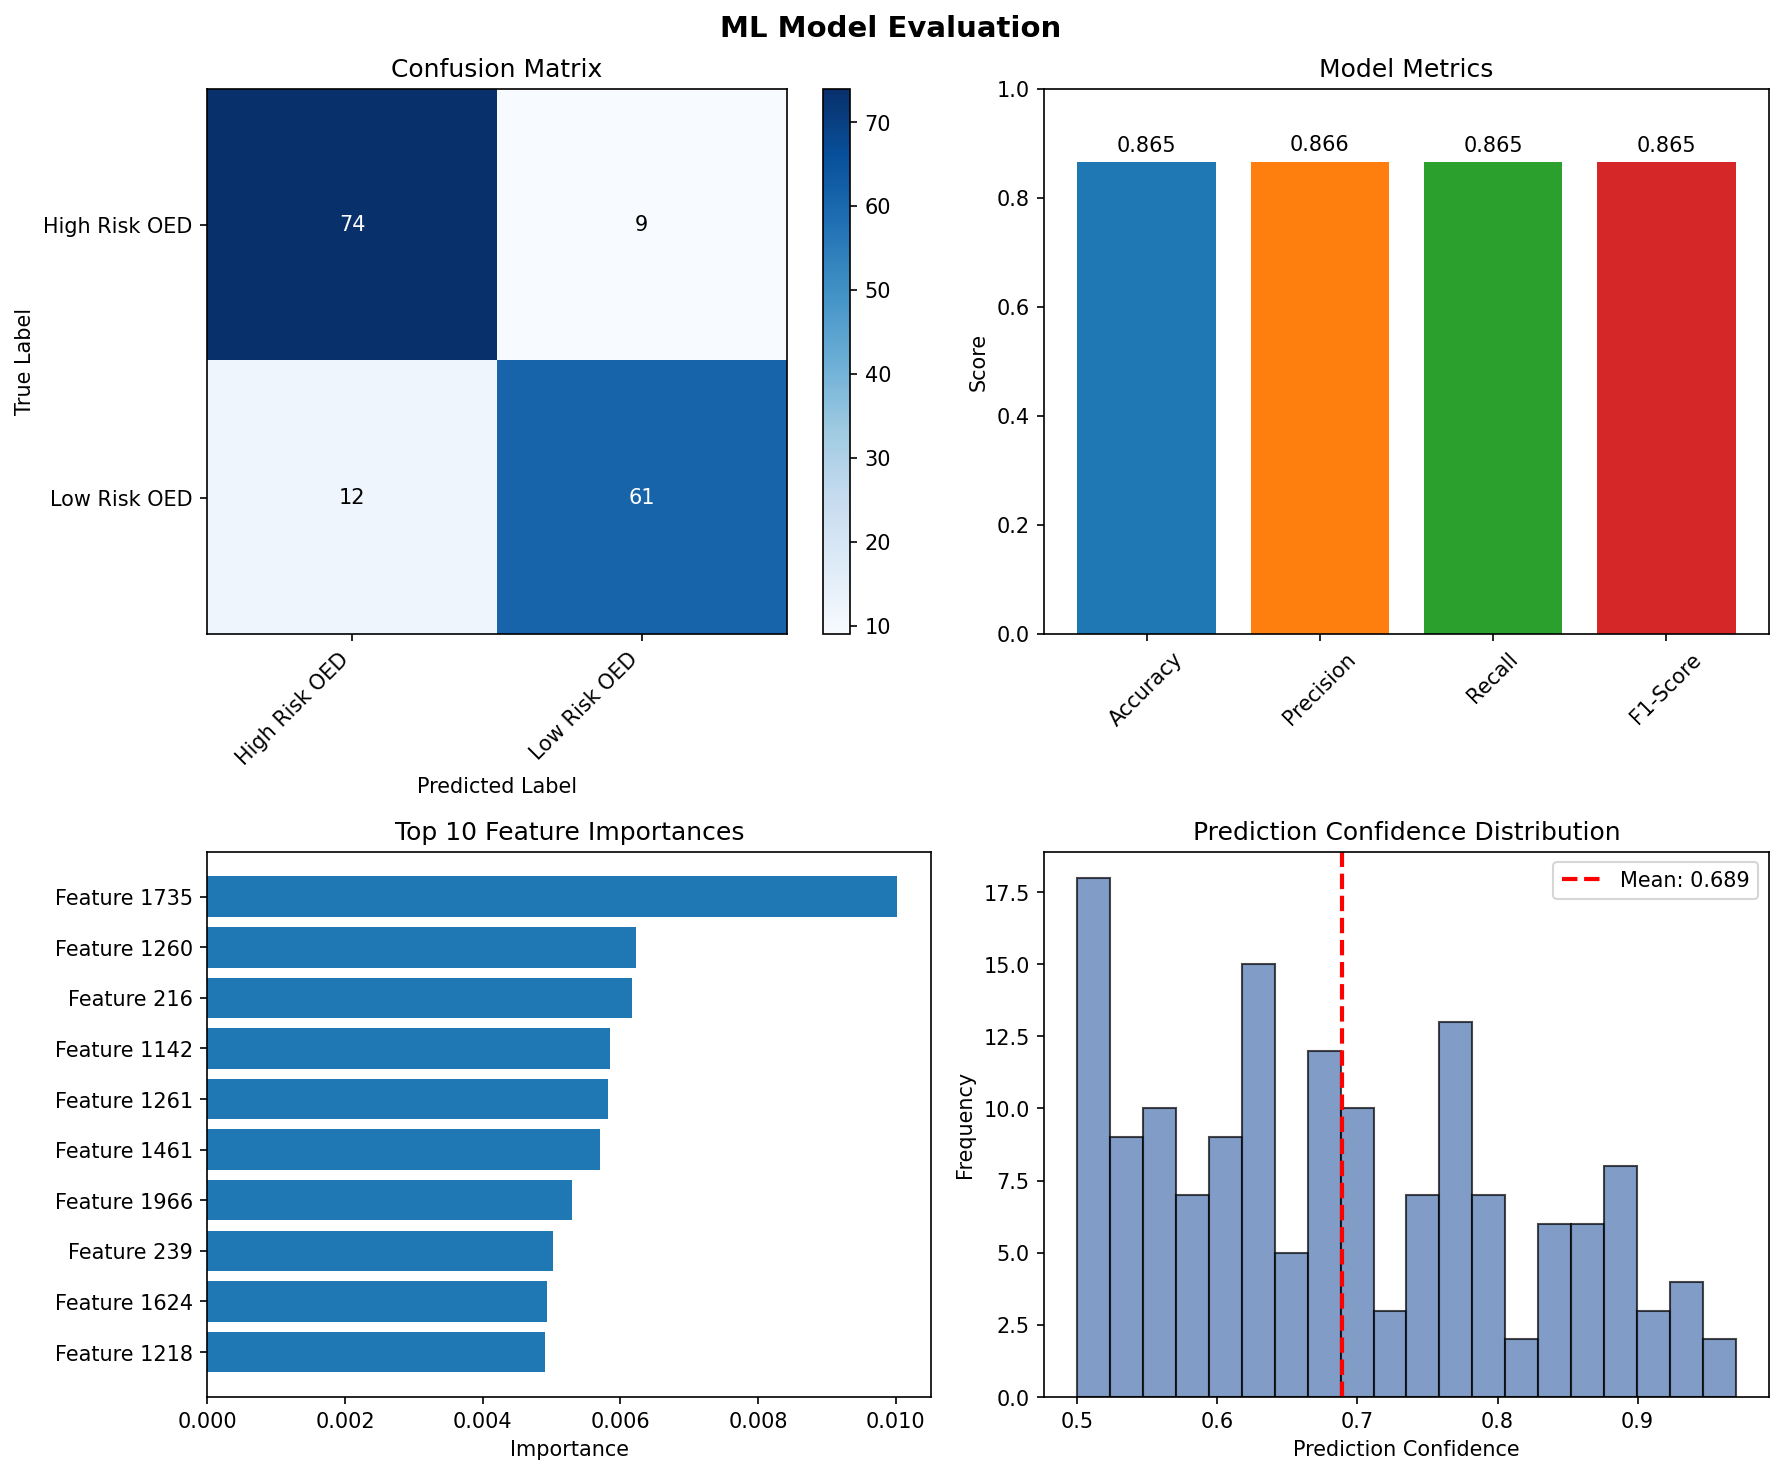

In [43]:
# Generate visualizations for model evaluation
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.patches as mpatches

# Create figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
im = axes[0, 0].imshow(cm, cmap='Blues', aspect='auto')
axes[0, 0].set_xlabel('Predicted Label')
axes[0, 0].set_ylabel('True Label')
axes[0, 0].set_title('Confusion Matrix')
class_names = [name for name, _ in sorted(class_map.items(), key=lambda x: x[1])]
axes[0, 0].set_xticks(range(len(class_names)))
axes[0, 0].set_yticks(range(len(class_names)))
axes[0, 0].set_xticklabels(class_names, rotation=45, ha='right')
axes[0, 0].set_yticklabels(class_names)
for i in range(len(class_names)):
    for j in range(len(class_names)):
        axes[0, 0].text(j, i, str(cm[i, j]), ha='center', va='center', color='white' if cm[i, j] > cm.max()/2 else 'black')
plt.colorbar(im, ax=axes[0, 0])

# 2. Metrics bar chart
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metrics_values = [test_acc, precision, recall, f1]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
axes[0, 1].bar(metrics_names, metrics_values, color=colors)
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_title('Model Metrics')
axes[0, 1].set_ylim([0, 1])
for i, v in enumerate(metrics_values):
    axes[0, 1].text(i, v + 0.02, f'{v:.3f}', ha='center')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Feature importance (top 10)
feature_importance = clf.feature_importances_
top_indices = np.argsort(feature_importance)[-10:]
top_importance = feature_importance[top_indices]
axes[1, 0].barh(range(len(top_importance)), top_importance)
axes[1, 0].set_yticks(range(len(top_importance)))
axes[1, 0].set_yticklabels([f'Feature {i}' for i in top_indices])
axes[1, 0].set_xlabel('Importance')
axes[1, 0].set_title('Top 10 Feature Importances')

# 4. Prediction confidence distribution
max_proba = np.max(y_pred_proba, axis=1)
axes[1, 1].hist(max_proba, bins=20, color='#4c72b0', edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Prediction Confidence')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Prediction Confidence Distribution')
axes[1, 1].axvline(np.mean(max_proba), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(max_proba):.3f}')
axes[1, 1].legend()

plt.suptitle('ML Model Evaluation', fontsize=14, fontweight='bold')
plt.tight_layout()
p = OUT_DIR / 'model_evaluation.png'
plt.savefig(p, dpi=150, bbox_inches='tight')
plt.close()

print(f'\nEvaluation plot saved to {p}')
from IPython.display import Image as DispImage
display(DispImage(str(p)))

In [44]:
# Save the trained model for future use
import pickle

model_dir = OUT_DIR / 'models'
model_dir.mkdir(exist_ok=True)

# Save the model and preprocessing objects
model_path = model_dir / 'oed_classifier.pkl'
scaler_path = model_dir / 'scaler.pkl'
class_map_path = model_dir / 'class_map.pkl'

with open(model_path, 'wb') as f:
    pickle.dump(clf, f)
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
with open(class_map_path, 'wb') as f:
    pickle.dump(class_map, f)

print(f'Model saved to {model_path}')
print(f'Scaler saved to {scaler_path}')
print(f'Class map saved to {class_map_path}')

Model saved to c:\Users\jehil\OneDrive\Documents\GitHub\epithelial-dysplasia\viz_outputs\models\oed_classifier.pkl
Scaler saved to c:\Users\jehil\OneDrive\Documents\GitHub\epithelial-dysplasia\viz_outputs\models\scaler.pkl
Class map saved to c:\Users\jehil\OneDrive\Documents\GitHub\epithelial-dysplasia\viz_outputs\models\class_map.pkl


Loaded 5 validation images
Processing image 1/5...


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished



Validation predictions saved to c:\Users\jehil\OneDrive\Documents\GitHub\epithelial-dysplasia\viz_outputs\validation_predictions.png


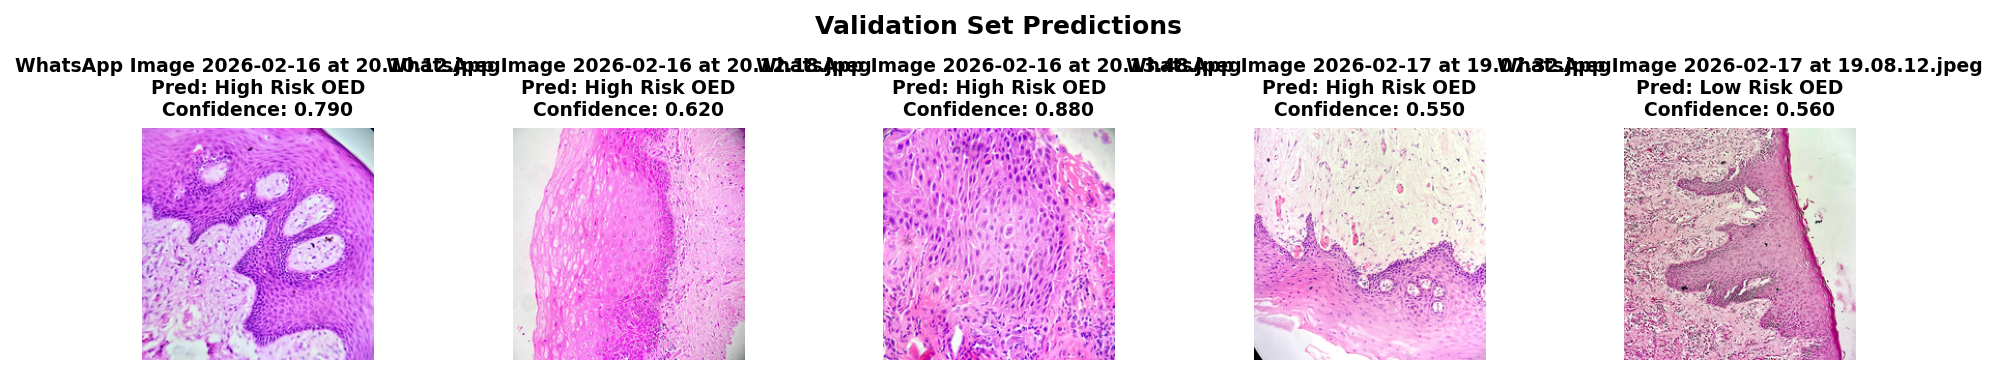

In [45]:
# Visualize predictions on validation images
validation_dir = ROOT / 'validation'

# Load validation images
validation_images = []
validation_paths = []
target_size = (224, 224)

if validation_dir.exists():
    for img_file in sorted(os.listdir(validation_dir)):
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = validation_dir / img_file
            try:
                img = Image.open(img_path).convert('RGB')
                img = img.resize(target_size, Image.Resampling.LANCZOS)
                validation_images.append(np.array(img))
                validation_paths.append(img_path.name)
            except Exception as e:
                print(f'Error loading {img_path}: {e}')
    
    print(f'Loaded {len(validation_images)} validation images')
    
    if len(validation_images) > 0:
        # Extract features for validation images
        validation_features = extract_features_resnet(np.array(validation_images))
        validation_features_scaled = scaler.transform(validation_features)
        
        # Make predictions
        validation_predictions = clf.predict(validation_features_scaled)
        validation_proba = clf.predict_proba(validation_features_scaled)
        
        # Visualize results
        n_cols = min(len(validation_images), 6)
        n_rows = (len(validation_images) + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*2.5, n_rows*2.5))
        
        # Handle single row/column case
        if n_rows == 1 and n_cols == 1:
            axes = np.array([[axes]])
        elif n_rows == 1:
            axes = np.expand_dims(axes, 0)
        elif n_cols == 1:
            axes = np.expand_dims(axes, 1)
        
        class_names = [name for name, _ in sorted(class_map.items(), key=lambda x: x[1])]
        
        for idx, (img, pred_label, conf) in enumerate(zip(validation_images, validation_predictions, np.max(validation_proba, axis=1))):
            row = idx // n_cols
            col = idx % n_cols
            ax = axes[row, col]
            
            # Display image
            ax.imshow(img.astype('uint8'))
            ax.axis('off')
            
            # Get prediction details
            pred_name = class_names[pred_label]
            title = f'{validation_paths[idx]}\nPred: {pred_name}\nConfidence: {conf:.3f}'
            ax.set_title(title, fontweight='bold', fontsize=9)
        
        # Hide empty subplots
        for idx in range(len(validation_images), n_rows * n_cols):
            row = idx // n_cols
            col = idx % n_cols
            axes[row, col].axis('off')
        
        plt.suptitle('Validation Set Predictions', fontsize=12, fontweight='bold')
        plt.tight_layout()
        p = OUT_DIR / 'validation_predictions.png'
        plt.savefig(p, dpi=150, bbox_inches='tight')
        plt.close()
        
        print(f'\nValidation predictions saved to {p}')
        display(DispImage(str(p)))
else:
    print(f'Validation directory not found at {validation_dir}')


VALIDATION SET EVALUATION
Processing image 1/5...


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished



Total validation images: 5

Image                               RF Prediction        RF Conf    SVM Prediction       SVM Conf  
-----------------------------------------------------------------------------------------------
WhatsApp Image 2026-02-16 at 20.10.12.jpeg High Risk OED        0.680      High Risk OED        0.555      ✓
WhatsApp Image 2026-02-16 at 20.12.18.jpeg High Risk OED        0.650      High Risk OED        0.793      ✓
WhatsApp Image 2026-02-16 at 20.13.48.jpeg High Risk OED        0.750      High Risk OED        0.582      ✓
WhatsApp Image 2026-02-17 at 19.07.32.jpeg Low Risk OED         0.590      Low Risk OED         0.899      ✓
WhatsApp Image 2026-02-17 at 19.08.12.jpeg High Risk OED        0.540      High Risk OED        0.564      ✓
-----------------------------------------------------------------------------------------------

Model Agreement: 100.0% (5/5)

VALIDATION PREDICTIONS SUMMARY

Random Forest Predictions:
  High Risk OED       : 4 images, avg confi

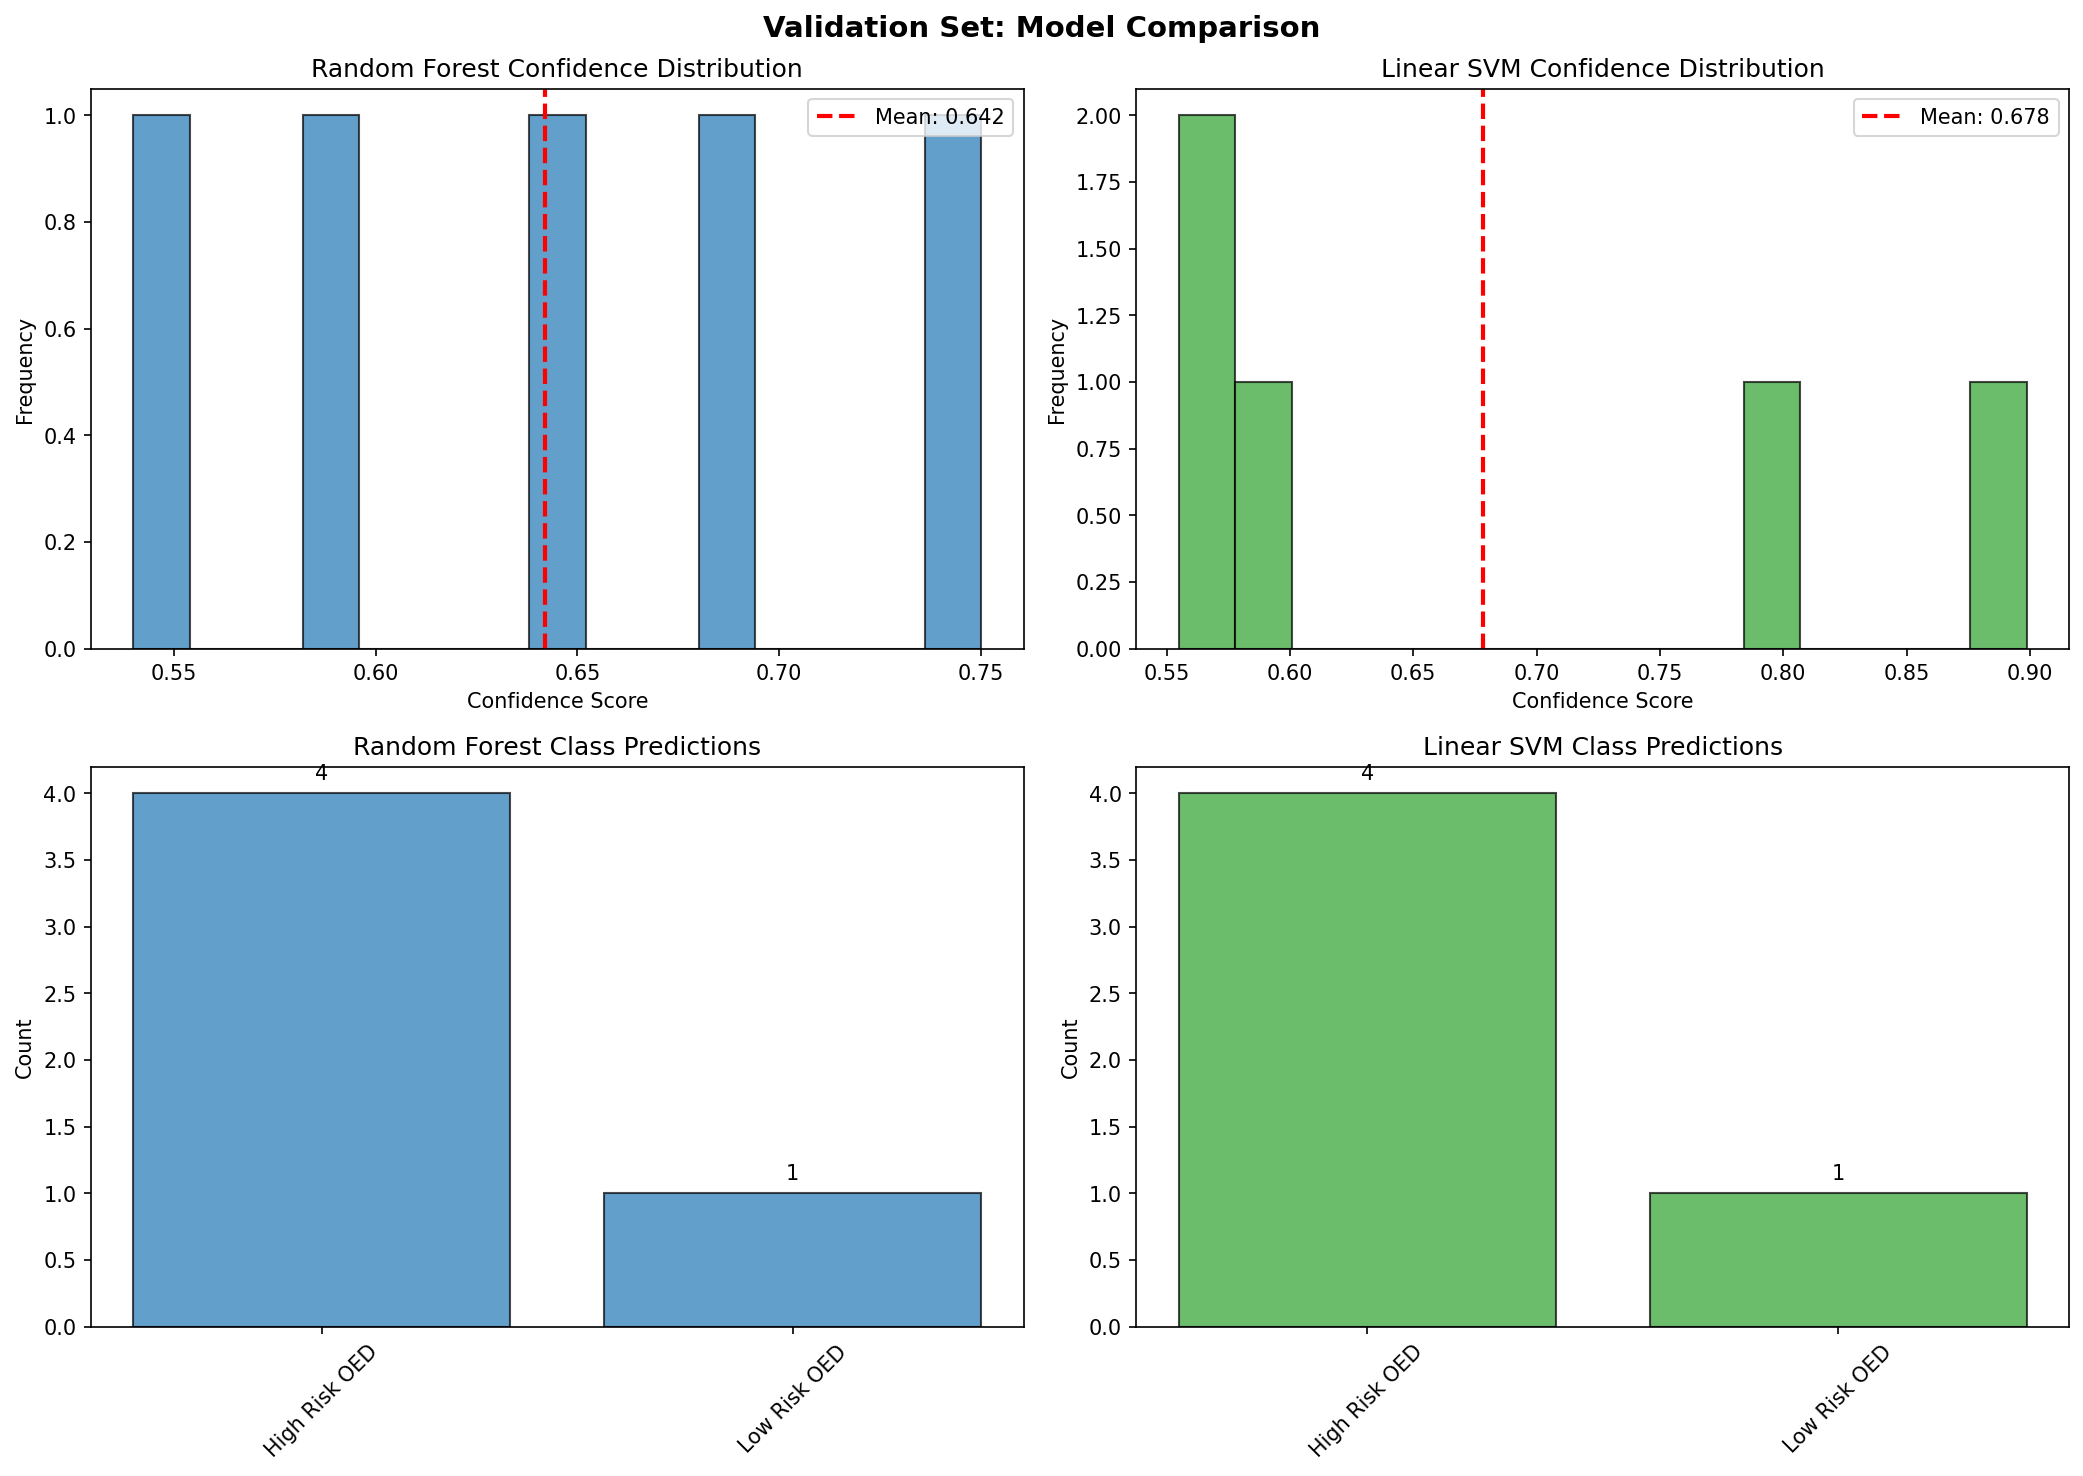

In [33]:
# Comprehensive evaluation of both models on validation images
if validation_dir.exists() and len(validation_images) > 0:
    print('\n' + '='*70)
    print('VALIDATION SET EVALUATION')
    print('='*70)
    
    # Get predictions from both models
    validation_features = extract_features_resnet(np.array(validation_images))
    validation_features_scaled = scaler.transform(validation_features)
    
    # Random Forest predictions
    rf_val_predictions = clf.predict(validation_features_scaled)
    rf_val_proba = clf.predict_proba(validation_features_scaled)
    rf_val_confidence = np.max(rf_val_proba, axis=1)
    
    # Linear SVM predictions
    svm_val_predictions = svm_clf.predict(validation_features_scaled)
    svm_val_decision = svm_clf.decision_function(validation_features_scaled)
    if len(np.unique(y)) == 2:
        svm_val_proba = expit(svm_val_decision)
        svm_val_proba = np.column_stack([1 - svm_val_proba, svm_val_proba])
    else:
        svm_val_proba = expit(svm_val_decision)
        svm_val_proba = svm_val_proba / svm_val_proba.sum(axis=1, keepdims=True)
    svm_val_confidence = np.max(svm_val_proba, axis=1)
    
    class_names = [name for name, _ in sorted(class_map.items(), key=lambda x: x[1])]
    
    print(f'\nTotal validation images: {len(validation_images)}\n')
    
    # Print predictions for each image
    print(f'{"Image":<35} {"RF Prediction":<20} {"RF Conf":<10} {"SVM Prediction":<20} {"SVM Conf":<10}')
    print('-'*95)
    
    for idx, (filename, rf_pred, rf_conf, svm_pred, svm_conf) in enumerate(zip(
        validation_paths, rf_val_predictions, rf_val_confidence, 
        svm_val_predictions, svm_val_confidence)):
        rf_class = class_names[rf_pred]
        svm_class = class_names[svm_pred]
        
        # Highlight agreement/disagreement
        match_marker = '✓' if rf_pred == svm_pred else '✗'
        
        print(f'{filename:<35} {rf_class:<20} {rf_conf:<10.3f} {svm_class:<20} {svm_conf:<10.3f} {match_marker}')
    
    # Calculate agreement between models
    agreement = np.sum(rf_val_predictions == svm_val_predictions) / len(validation_images) * 100
    
    print('-'*95)
    print(f'\nModel Agreement: {agreement:.1f}% ({np.sum(rf_val_predictions == svm_val_predictions)}/{len(validation_images)})')
    
    # Summary statistics
    print('\n' + '='*70)
    print('VALIDATION PREDICTIONS SUMMARY')
    print('='*70)
    
    print('\nRandom Forest Predictions:')
    for class_id, class_name in enumerate(class_names):
        count = np.sum(rf_val_predictions == class_id)
        avg_conf = np.mean(rf_val_confidence[rf_val_predictions == class_id]) if count > 0 else 0
        print(f'  {class_name:<20}: {count} images, avg confidence: {avg_conf:.3f}')
    
    print('\nLinear SVM Predictions:')
    for class_id, class_name in enumerate(class_names):
        count = np.sum(svm_val_predictions == class_id)
        avg_conf = np.mean(svm_val_confidence[svm_val_predictions == class_id]) if count > 0 else 0
        print(f'  {class_name:<20}: {count} images, avg confidence: {avg_conf:.3f}')
    
    # Create comparison visualization
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. RF Confidence Distribution
    axes[0, 0].hist(rf_val_confidence, bins=15, color='#1f77b4', edgecolor='black', alpha=0.7)
    axes[0, 0].set_xlabel('Confidence Score')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Random Forest Confidence Distribution')
    axes[0, 0].axvline(np.mean(rf_val_confidence), color='red', linestyle='--', 
                       linewidth=2, label=f'Mean: {np.mean(rf_val_confidence):.3f}')
    axes[0, 0].legend()
    
    # 2. SVM Confidence Distribution
    axes[0, 1].hist(svm_val_confidence, bins=15, color='#2ca02c', edgecolor='black', alpha=0.7)
    axes[0, 1].set_xlabel('Confidence Score')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Linear SVM Confidence Distribution')
    axes[0, 1].axvline(np.mean(svm_val_confidence), color='red', linestyle='--', 
                       linewidth=2, label=f'Mean: {np.mean(svm_val_confidence):.3f}')
    axes[0, 1].legend()
    
    # 3. Prediction Distribution - Random Forest
    rf_counts = [np.sum(rf_val_predictions == i) for i in range(len(class_names))]
    axes[1, 0].bar(class_names, rf_counts, color='#1f77b4', edgecolor='black', alpha=0.7)
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].set_title('Random Forest Class Predictions')
    axes[1, 0].tick_params(axis='x', rotation=45)
    for i, count in enumerate(rf_counts):
        axes[1, 0].text(i, count + 0.1, str(count), ha='center')
    
    # 4. Prediction Distribution - Linear SVM
    svm_counts = [np.sum(svm_val_predictions == i) for i in range(len(class_names))]
    axes[1, 1].bar(class_names, svm_counts, color='#2ca02c', edgecolor='black', alpha=0.7)
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].set_title('Linear SVM Class Predictions')
    axes[1, 1].tick_params(axis='x', rotation=45)
    for i, count in enumerate(svm_counts):
        axes[1, 1].text(i, count + 0.1, str(count), ha='center')
    
    plt.suptitle('Validation Set: Model Comparison', fontsize=14, fontweight='bold')
    plt.tight_layout()
    p = OUT_DIR / 'validation_model_comparison.png'
    plt.savefig(p, dpi=150, bbox_inches='tight')
    plt.close()
    
    print(f'\nComparison visualization saved to {p}')
    display(DispImage(str(p)))
    
    print('='*70)
else:
    print('No validation images found or validation directory does not exist')